✅ Dataset loaded successfully!
✅ Vision Transformer models initialized!
✅ Distillation loss function defined!


C:\Users\user\AppData\Local\Temp\ipykernel_12892\2196148374.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\user\AppData\Local\Temp\ipykernel_12892\2196148374.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/5] - Loss: 1.1969 | Train Acc: 35.15% | Val Acc: 55.56%
Epoch [2/5] - Loss: 0.8866 | Train Acc: 68.90% | Val Acc: 55.12%
Epoch [3/5] - Loss: 0.7120 | Train Acc: 86.94% | Val Acc: 81.62%
Epoch [4/5] - Loss: 0.6208 | Train Acc: 94.98% | Val Acc: 81.12%
Epoch [5/5] - Loss: 0.5881 | Train Acc: 97.62% | Val Acc: 83.06%
+-------+--------------------+-------------+--------------+--------+
| Epoch |   Train Acc (%)    | Val Acc (%) | Test Acc (%) |   LR   |
+-------+--------------------+-------------+--------------+--------+
|   1   | 35.145833333333336 |   55.5625   |    81.125    | 0.0005 |
|   2   | 68.89583333333333  |    55.125   |    81.125    | 0.0005 |
|   3   |      86.9375       |    81.625   |    81.125    | 0.0005 |
|   4   | 94.97916666666667  |    81.125   |    81.125    | 0.0005 |
|   5   |       97.625       |   83.0625   |    81.125    | 0.0005 |
+-------+--------------------+-------------+--------------+--------+


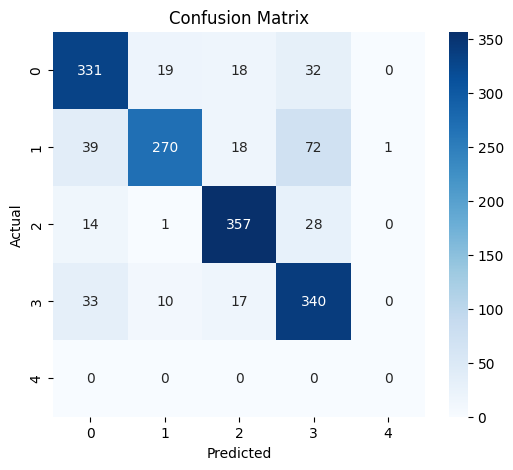

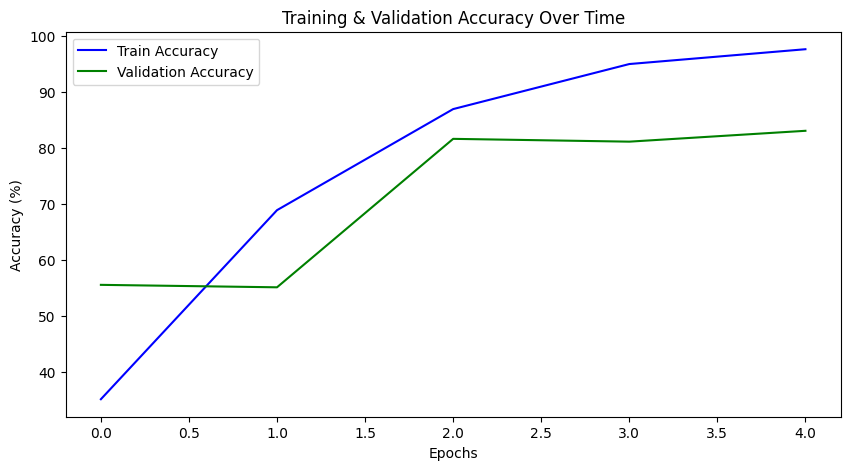

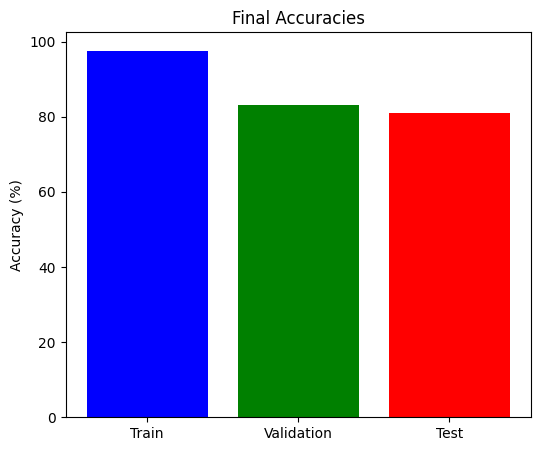

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time
import timm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
from colored import fg, attr

# Suppress CUDA errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define colors
SUCCESS = fg('green')
WARNING = fg('yellow')
RESET = attr('reset')

# Data Loader
def get_dataloader(batch_size=128, num_workers=4):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\train', transform=transform)
    val_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\val', transform=transform)
    test_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\test', transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloader()
print(f"{SUCCESS}✅ Dataset loaded successfully!{RESET}")

# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", num_classes=10):
        super(VisionTransformer, self).__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

teacher_model = VisionTransformer(model_name="vit_base_patch16_224")
student_model = VisionTransformer(model_name="vit_tiny_patch16_224")
print(f"{SUCCESS}✅ Vision Transformer models initialized!{RESET}")

# Knowledge Distillation Loss
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=4.0):
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_targets = torch.nn.functional.log_softmax(student_logits / self.temperature, dim=1)
        teacher_targets = torch.nn.functional.softmax(teacher_logits / self.temperature, dim=1)

        distillation_loss = self.kl_div(soft_targets, teacher_targets) * (self.temperature ** 2)
        classification_loss = self.ce_loss(student_logits, labels)

        return self.alpha * distillation_loss + (1 - self.alpha) * classification_loss

print(f"{SUCCESS}✅ Distillation loss function defined!{RESET}")

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return 100 * correct / total, predictions, true_labels

# Training function
def train_validate_test(teacher, student, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    teacher.eval().to(device)
    student.to(device)

    optimizer = optim.Adam(student.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    loss_fn = DistillationLoss()
    scaler = GradScaler()

    best_val_acc = 0
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(epochs):
        start_time = time.time()
        student.train()
        correct, total, total_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                teacher_outputs = teacher(images)

            optimizer.zero_grad()

            with autocast():
                student_outputs = student(images)
                loss = loss_fn(student_outputs, teacher_outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        scheduler.step()

        val_acc, _, _ = evaluate(student, val_loader, device)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"{WARNING}Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%{RESET}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), "best_student.pth")

    test_acc, y_pred, y_true = evaluate(student, test_loader, device)
    test_accuracies.append(test_acc)

    # Pretty Table
    table = PrettyTable(["Epoch", "Train Acc (%)", "Val Acc (%)", "Test Acc (%)", "LR"])
    for i in range(epochs):
        table.add_row([i+1, train_accuracies[i], val_accuracies[i], test_acc, lr])
    print(table)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Line Graphs
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy Over Time')
    plt.legend()
    plt.show()

    # Bar Graph
    plt.figure(figsize=(6, 5))
    plt.bar(['Train', 'Validation', 'Test'], [train_accuracies[-1], val_accuracies[-1], test_acc], color=['blue', 'green', 'red'])
    plt.ylabel('Accuracy (%)')
    plt.title('Final Accuracies')
    plt.show()

train_validate_test(teacher_model, student_model, train_loader, val_loader, test_loader, epochs=5, lr=0.0005)


In [41]:
import torch
from timm import create_model

# Load the raw state_dict
checkpoint = torch.load("best_student.pth", map_location=torch.device("cpu"))

# Adjust key names if they are stored under "model."
if "model" in checkpoint:
    checkpoint = checkpoint["model"]  # Extract the actual model state_dict

# Create model architecture
student_model = create_model("vit_tiny_patch16_224", pretrained=False, num_classes=10)

# Load adjusted state_dict
student_model.load_state_dict(checkpoint, strict=False)  # `strict=False` allows missing or extra keys

# Set model to evaluation mode
student_model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [42]:
checkpoint = torch.load("best_student.pth", map_location=torch.device("cpu"))
print(checkpoint.keys())


odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [26]:
checkpoint = {k.replace("model.", ""): v for k, v in checkpoint.items()}
student_model.load_state_dict(checkpoint, strict=False)


_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.ml

In [28]:
import torch

# Define example input (assuming image size is 224x224)
example_input = torch.randn(1, 3, 224, 224)

# Convert model to TorchScript
scripted_model = torch.jit.trace(student_model, example_input)

# Save the scripted model
torch.jit.save(scripted_model, "student_model_scripted.pt")

print("✅ Model successfully converted to TorchScript!")


✅ Model successfully converted to TorchScript!


In [ ]:
import torch
import torch.nn.functional as F
from flask import Flask, request, jsonify
from PIL import Image
import io
import torchvision.transforms as transforms
import threading

# Initialize Flask app
app = Flask(__name__)

# Load the TorchScript model
model = torch.jit.load("student_model_scripted.pt", map_location="cpu")
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define class labels
class_labels = ["longberry", "peaberry", "premium", "defect"]

# Home Route
@app.route("/")  
def home():
    return jsonify({"message": "Welcome to the Coffee Bean Quality Estimation API!"})

# Prediction Route
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # Get the image from request
        file = request.files["file"]
        image = Image.open(io.BytesIO(file.read())).convert("RGB")

        # Preprocess the image
        image = transform(image).unsqueeze(0)  # Add batch dimension

        # Perform inference
        with torch.no_grad():
            output = model(image)
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()

        # Return the predicted label
        return jsonify({"prediction": class_labels[predicted_class], "confidence": probabilities[0][predicted_class].item()})

    except Exception as e:
        return jsonify({"error": str(e)})

# Run the Flask app
def run_app():
    app.run(host="0.0.0.0", port=5003)

thread = threading.Thread(target=run_app)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5003
 * Running on http://10.10.134.78:5003
Press CTRL+C to quit


In [37]:
image_path = "C:/Users/user/Desktop/CSC YEAR 2/SEM 2/MACHINE LEARNING/dataset3/USK-Coffee/val/premium/90.jpg"
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image)
    print("Raw Model Output:", output)

    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

print("Predicted Class:", predicted_class)
print("Confidence:", probabilities[0][predicted_class].item())
print("Class Labels Order:", class_labels)


Raw Model Output: tensor([[-0.3614,  0.1826,  0.1088,  0.0728, -0.2751, -0.0037, -0.0817, -0.2012,
         -0.1305,  0.0707]])
Predicted Class: 1
Confidence: 0.12590359151363373
Class Labels Order: ['longberry', 'peaberry', 'premium', 'defect']
